In [4]:
import os
import glob
import csv

In [5]:
PARENT = "/data/holly_jackson/experiments"
# out_csv = "summary_metrics_all_test_all_batches.csv"
# exp_name_format = "coord-descent-aif-init-????_2025-08-20_*"
exp_name_format = "all-test-????_2025-08-2*"

In [6]:
def parse_last_loss(losses_path):
    # todo: this reads whole file not super efficient
    with open(losses_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip(): # not blank
                last = line.strip()
    return float(last)

def parse_accuracy_metrics(metrics_path):
    rms = rel = d1 = d2 = d3 = None
    with open(metrics_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.lower().startswith("rms"):
                rms = float(line.split(":")[1].strip())
            elif line.lower().startswith("rel"):
                rel = float(line.split(":")[1].strip())
            elif line.lower().startswith("accuracy"):
                right = line.split(":")[1].strip()
                d1, d2, d3 = [float(x.strip()) for x in right.split(",")]
    return (rms, rel, d1, d2, d3)

In [7]:
rows = []
pattern = os.path.join(PARENT, exp_name_format)
dirs = [d for d in glob.glob(pattern) if os.path.isdir(d)]

# remove repeats + sort
dirs = sorted(set(dirs))


In [23]:

for d in dirs:
    # print(d)
    run_id = os.path.basename(d).split("_")[0].split("-")[-1]
    # print(run_id)
        
    losses_path = os.path.join(d, "losses.txt")
    metrics_path = os.path.join(d, "accuracy_metrics.txt")

    if not os.path.exists(losses_path) or not os.path.exists(metrics_path):
        continue
    
    last_loss = parse_last_loss(losses_path)
    # print(last_loss)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)
    # print(rms, rel, d1, d2, d3)

    rows.append({
        "run_id": run_id,
        "last_loss": last_loss,
        "RMS": rms,
        "Rel": rel,
        "delta1": d1,
        "delta2": d2,
        "delta3": d3,
    })


# write to csv all at once
fieldnames = ["run_id", "last_loss", "RMS", "Rel", "delta1", "delta2", "delta3"]
rows.sort(key=lambda r: r["run_id"])

avg_row = {"run_id": "AVERAGE"}
for col in fieldnames[1:]:
    values = [r[col] for r in rows if r[col] is not None]
    avg_row[col] = sum(values) / len(values) if values else None

rows.append(avg_row)

with open(out_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=fieldnames
    )
    writer.writeheader()
    writer.writerows(rows)

print(f"Wrote {len(rows)} rows to {out_csv}")

Wrote 655 rows to summary_metrics_all_test_all_batches.csv


In [8]:
import utils 
import forward_model
import globals

globals.init_NYUv2()

IMAGE_RANGE = 255.

# load data 
gt_aif, gt_dpt = utils.load_single_sample(sample='0045', set='train', fs=5, res='half')
# gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

width, height = gt_dpt.shape

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

defocus_stack = forward_model.forward(gt_dpt, gt_aif)


adaptive kernel size set to 11


In [9]:
import matplotlib.pyplot as plt
import section_search
import utils
import math

count = 0

worst_rms = 0
worst_file = None
best_rms = float('inf')
best_file = None

for d in dirs:

    # print(d)
    run_id = os.path.basename(d).split("_")[0].split("-")[-1]
    # print(run_id)
        
    losses_path = os.path.join(d, "losses.txt")
    metrics_path = os.path.join(d, "accuracy_metrics.txt")

    if not os.path.exists(losses_path) or not os.path.exists(metrics_path):
        continue

    last_loss = parse_last_loss(losses_path)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)

    if rms > worst_rms:
        worst_rms = rms
        worst_file = d
    if rms < best_rms:
        best_rms = rms
        best_file = d
    
    # dpt_test = utils.load_NYUv2_dpt(os.path.join(d, "dpt.tiff"), 1)
    # aif_test = utils.load_NYUv2_aif(os.path.join(d, "aif.tiff"), 1) * IMAGE_RANGE
        
    # defocus_stack_test = forward_model.forward(dpt_test, aif_test)

    # gt_aif, gt_dpt = utils.load_single_sample(sample=run_id, set='train', fs=5, res='half')
    # gt_aif = gt_aif * IMAGE_RANGE

    # absrel = utils.compute_AbsRel(dpt_test, gt_dpt)
    # print(rel, absrel)
    # assert math.isclose(absrel, rel, rel_tol=1e-5, abs_tol=1e-5)

    
    # utils.plot_compare_greyscale(dpt_test, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
    # plt.show()

    # # TODO: need to fix this code but after entire set runs 
    # dpt_no_outliers = section_search.remove_outliers(
    #     dpt_test, aif_test, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
    
    # utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
    # plt.show()
    
    # utils.plot_compare_greyscale(aif_test / IMAGE_RANGE, gt_aif / IMAGE_RANGE)
    # plt.show()


    

    print('mse:',last_loss, ', rms:', rms)
    
    count += 1
    


mse: 6.78749565850012e-05 , rms: 0.02233
mse: 0.0003368356847204268 , rms: 0.002182
mse: 0.0003480312298052013 , rms: 0.017778
mse: 0.0001083942552213557 , rms: 0.062578
mse: 0.00020329191465862095 , rms: 0.020103
mse: 0.000122841855045408 , rms: 0.018927
mse: 0.00020115954976063222 , rms: 0.084487
mse: 0.00010133750038221478 , rms: 0.025964
mse: 0.0001153811244876124 , rms: 0.005547
mse: 2.869118907256052e-05 , rms: 0.012561
mse: 0.0001390104298479855 , rms: 0.111473
mse: 2.3460683223675005e-05 , rms: 0.012709
mse: 0.00011891031317645684 , rms: 0.144787
mse: 0.0001340586895821616 , rms: 0.007788
mse: 0.00014900030510034412 , rms: 0.122307
mse: 9.135125583270565e-05 , rms: 0.051821
mse: 5.6348562793573365e-05 , rms: 0.266483
mse: 2.5241493858629838e-05 , rms: 0.34173
mse: 7.469591946573928e-05 , rms: 0.024095
mse: 0.00012038998829666525 , rms: 0.005538
mse: 8.443526166956872e-05 , rms: 0.02547
mse: 9.573335410095751e-05 , rms: 0.001577
mse: 0.00018874480156227946 , rms: 0.030396
mse: 0

/data/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


5.8527832152321935e-05 1.396605 0.066041


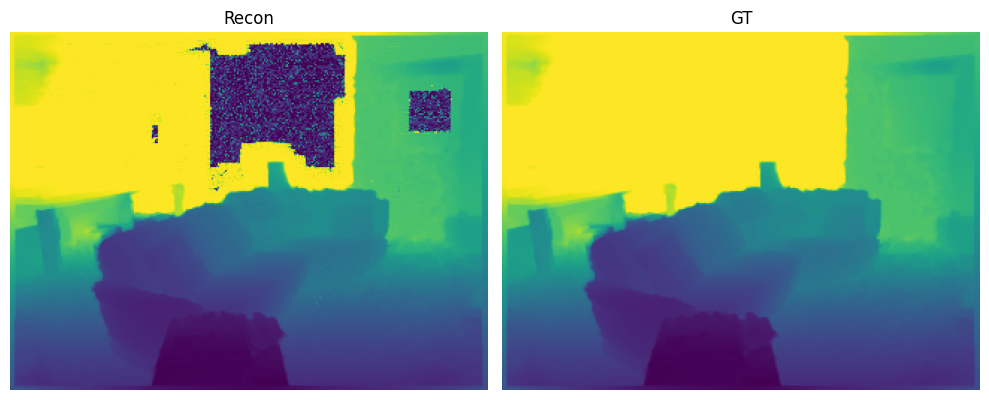

Removing outliers...
found 10403 outliers


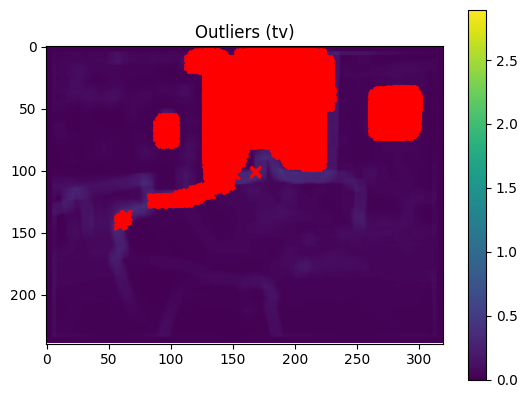

10403 / 10403 outliers removed


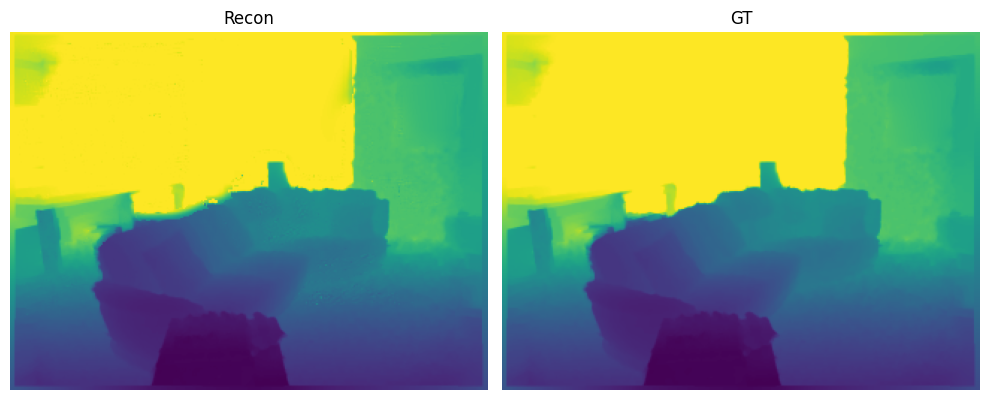

new RMS 0.06044889
new MSE 6325.5024


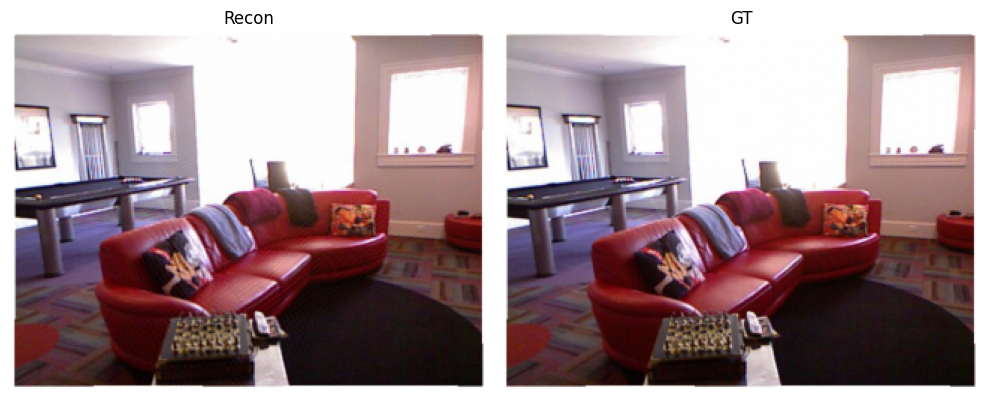

In [28]:
import utils
import os
import coordinate_descent
d = worst_file
dpt_test = utils.load_NYUv2_dpt(os.path.join(d, "dpt.tiff"), 1)
aif_test = utils.load_NYUv2_aif(os.path.join(d, "aif.tiff"), 1) * IMAGE_RANGE

run_id = os.path.basename(d).split("_")[0].split("-")[-1]

losses_path = os.path.join(d, "losses.txt")
metrics_path = os.path.join(d, "accuracy_metrics.txt")

last_loss = parse_last_loss(losses_path)
rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)
print(last_loss, rms, rel)

defocus_stack_test = forward_model.forward(dpt_test, aif_test)

gt_aif, gt_dpt = utils.load_single_sample(sample=run_id, set='test', fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

utils.plot_compare_greyscale(dpt_test, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()

# # TODO: need to fix this code but after entire set runs 
dpt_no_outliers, _ = section_search.remove_outliers(
    dpt_test, aif_test, diff_thresh = 2, tv_thresh = 0.4, patch_type = 'tv')

defocus_stack_test_no_outliers = forward_model.forward(dpt_no_outliers, aif_test)

utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()
print('new RMS', utils.compute_RMS(dpt_no_outliers, gt_dpt))
print('new MSE', coordinate_descent.mse_loss(
    defocus_stack_test_no_outliers, defocus_stack))

utils.plot_compare_greyscale(aif_test / IMAGE_RANGE, gt_aif / IMAGE_RANGE)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import section_search
import utils
import math


count = 0
worst_rms = 0
worst_file = None
best_rms = 0
best_file = None

for d in dirs:

    # print(d)
    run_id = os.path.basename(d).split("_")[0].split("-")[-1]
    # print(run_id)
        
    losses_path = os.path.join(d, "losses.txt")
    metrics_path = os.path.join(d, "accuracy_metrics.txt")

    if not os.path.exists(losses_path) or not os.path.exists(metrics_path):
        continue

    last_loss = parse_last_loss(losses_path)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)

    
    dpt_test = utils.load_NYUv2_dpt(os.path.join(d, "dpt.tiff"), 1)
    aif_test = utils.load_NYUv2_aif(os.path.join(d, "aif.tiff"), 1) * IMAGE_RANGE
        
    defocus_stack_test = forward_model.forward(dpt_test, aif_test)

    gt_aif, gt_dpt = utils.load_single_sample(sample=run_id, set='train', fs=5, res='half')
    gt_aif = gt_aif * IMAGE_RANGE

    absrel = utils.compute_AbsRel(dpt_test, gt_dpt)
    print(rel, absrel)
    assert math.isclose(absrel, rel, rel_tol=1e-5, abs_tol=1e-5)

    
    # utils.plot_compare_greyscale(dpt_test, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
    # plt.show()

    # # TODO: need to fix this code but after entire set runs 
    # dpt_no_outliers = section_search.remove_outliers(
    #     dpt_test, aif_test, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
    
    # utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
    # plt.show()
    
    # utils.plot_compare_greyscale(aif_test / IMAGE_RANGE, gt_aif / IMAGE_RANGE)
    # plt.show()


    

    print('mse:',last_loss, ', rms:', rms)
    
    count += 1
    


In [33]:
import coordinate_descent
import math

mse_test = coordinate_descent.mse_loss(defocus_stack_test, defocus_stack)
rms_test = utils.compute_RMS(dpt_test, gt_dpt)
rel_test = utils.compute_Rel(dpt_test, gt_dpt)
deltas_test = utils.compute_accuracy_metrics(dpt_test, gt_dpt)

print(mse_test, last_loss)
assert math.isclose(mse_test, last_loss, rel_tol=1e-6, abs_tol=1e-6)

print(rms_test, rms)
assert math.isclose(rms_test, rms, rel_tol=1e-6, abs_tol=1e-6)

print(rel_test, rel)
assert math.isclose(rel_test, rel, rel_tol=1e-6, abs_tol=1e-6)

print(deltas_test, d1, d2, d3)
assert math.isclose(deltas_test["delta1"], d1, rel_tol=1e-6, abs_tol=1e-6)
assert math.isclose(deltas_test["delta2"], d2, rel_tol=1e-6, abs_tol=1e-6)
assert math.isclose(deltas_test["delta3"], d3, rel_tol=1e-6, abs_tol=1e-6)

8.896098 4.231045722961426


AssertionError: 

0.0 1.0


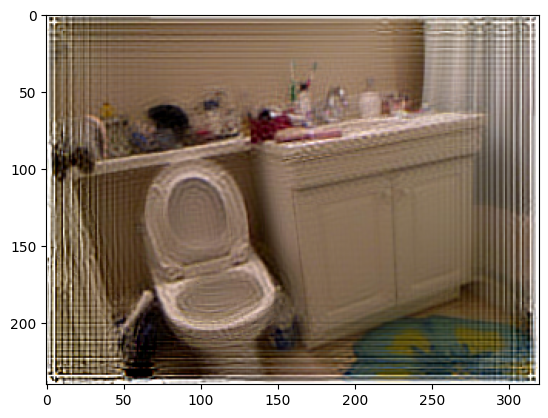

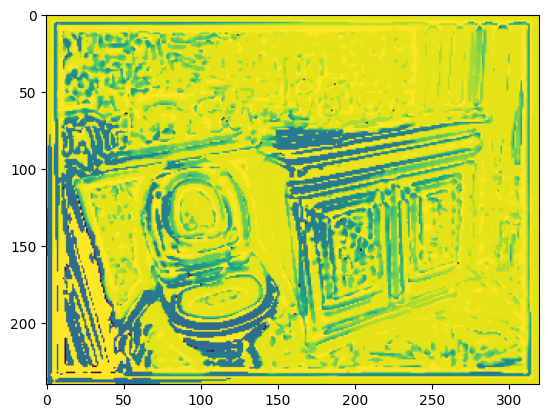

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.006699229..1.0276929].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.006528925..1.0229076].


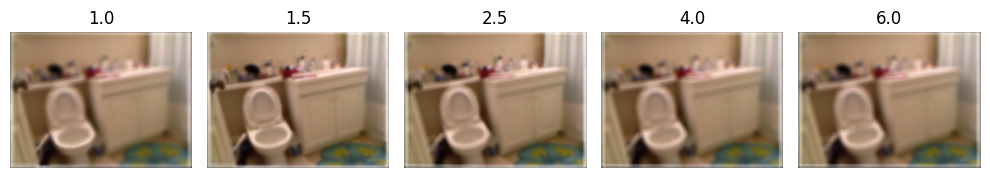

In [31]:
import matplotlib.pyplot as plt
print(aif_test.min(), aif_test.max())
plt.imshow(aif_test )
plt.show()

plt.imshow(dpt_test, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()

utils.plot_single_stack(defocus_stack_test, globals.Df)